# Graph Learning

## Lab 7: Graph Neural Networks

In this lab, you will learn to classify nodes using a graph neural network (GNN).

## Import

In [ ]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit-network

In [ ]:
from sknetwork.classification import get_accuracy_score
from sknetwork.data import load_netset
from sknetwork.embedding import Spectral
from sknetwork.gnn import GNNClassifier
from sknetwork.utils import directed2undirected

from sklearn.manifold import TSNE

## Data

We will work on the following datasets (see the [NetSet](https://netset.telecom-paris.fr/) collection for details):
* Cora (directed graph + bipartite graph)
* WikiVitals (directed graph + bipartite graph)

Both datasets are graphs with node features (given by the bipartite graph) and ground-truth labels.

In [ ]:
cora = load_netset('cora')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


In [ ]:
def visualize_embedding(embedding, labels, size=(6,6)):
    """Visualize embedding in 2 dimensions using TSNE. """
    print("Computing TSNE...")
    tsne = TSNE(random_state=8).fit_transform(embedding)
    fig, ax = plt.subplots(1, 1, figsize=size)
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, s=50, cmap='hsv')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## 1. Cora

We start with the Cora dataset. We check the embedding of the nodes before and after learning, and the impact of the GNN architecture on accuracy.

In [ ]:
dataset = cora

In [ ]:
adjacency = dataset.adjacency
features = dataset.biadjacency
labels_true = dataset.labels

In [ ]:
# we use undirected graphs
adjacency = directed2undirected(adjacency)

## To do

Consider a GNN with a single hidden layer of dimension 16.

* Run a single forward pass on the data, without learning.
* Display the embedding provided by the hidden layer.

In [ ]:
hidden_dim = 16

In [ ]:
n_labels = len(set(labels_true))

In [ ]:
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)

In [ ]:
gnn

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [ ]:
output = gnn.forward(adjacency, features)

In [ ]:
# hidden layer
embedding = gnn.layers[0].embedding

Computing TSNE...


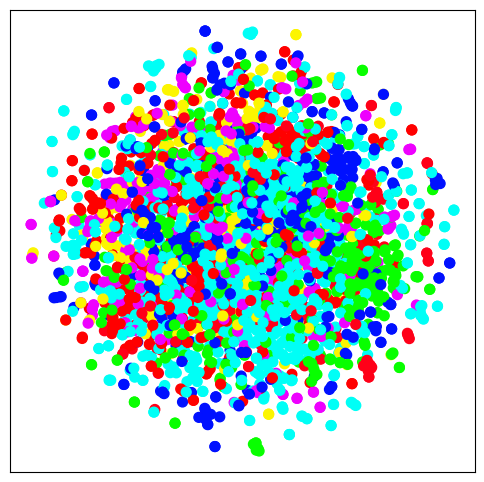

In [ ]:
visualize_embedding(embedding, labels_true)

## To do

We now train the GNN.

* Train the GNN with 50% / 50% train / test split.
* Give the accuracy of the classification on the train and test sets.
* Give the total number of parameters.
* Display the embedding provided by the hidden layer.

In [ ]:
# train / test split
ratio_train = 0.5
labels = labels_true.copy()
mask_train = np.random.random(size=len(labels)) < ratio_train
mask_test = ~mask_train
labels[mask_test] = -1

In [ ]:
gnn.fit(adjacency, features, labels)

In epoch   0, loss: 2.027, train accuracy: 0.097
In epoch  10, loss: 1.698, train accuracy: 0.574
In epoch  20, loss: 1.458, train accuracy: 0.832
In epoch  30, loss: 1.305, train accuracy: 0.928
In epoch  40, loss: 1.235, train accuracy: 0.965
In epoch  50, loss: 1.207, train accuracy: 0.977
In epoch  60, loss: 1.194, train accuracy: 0.984
In epoch  70, loss: 1.185, train accuracy: 0.989
In epoch  80, loss: 1.180, train accuracy: 0.992
In epoch  90, loss: 1.176, train accuracy: 0.996


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [ ]:
labels_pred = gnn.predict()

In [ ]:
for split, mask in [('Train', mask_train), ('Test', mask_test)]:
    accuracy = get_accuracy_score(labels_true[mask], labels_pred[mask])
    print(f'{split} accuracy:', accuracy)
    if split == 'Train':
        acc_train = accuracy
    else:
        acc_test = accuracy

Train accuracy: 0.9969811320754717
Test accuracy: 0.8004338394793926


In [ ]:
n_features = features.shape[-1]

layer1_params = n_features * hidden_dim + hidden_dim
layer2_params = hidden_dim * n_labels + n_labels
total_params = layer1_params + layer2_params

print(f'Total number of parameters in the GNN: {total_params}')

Total number of parameters in the GNN: 23063


Computing TSNE...


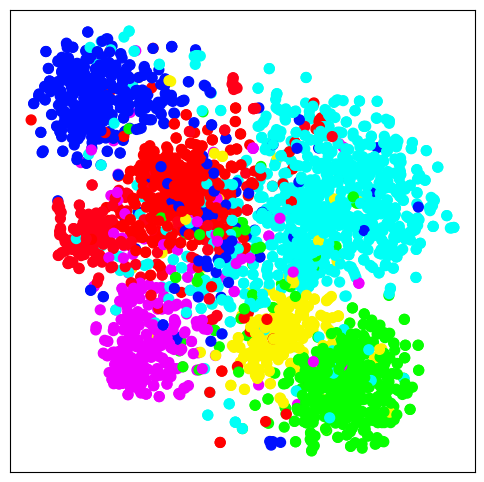

In [ ]:
embedding = gnn.layers[0].embedding
visualize_embedding(embedding, labels_true)

## To do

* Retrain the GNN with an empty graph.
* Compare the accuracy of the classification with that of the previous model.
* Comment the results. <br>What is the learning model?

In [ ]:
empty = sparse.csr_matrix(adjacency.shape)

In [ ]:
labels_empty = np.where(mask_test, -1, labels_true)

In [ ]:
gnn_empty = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)
gnn_empty.fit(empty, features, labels_empty)

In epoch   0, loss: 1.977, train accuracy: 0.132
In epoch  10, loss: 1.748, train accuracy: 0.489
In epoch  20, loss: 1.537, train accuracy: 0.765
In epoch  30, loss: 1.365, train accuracy: 0.897
In epoch  40, loss: 1.264, train accuracy: 0.968
In epoch  50, loss: 1.216, train accuracy: 0.984
In epoch  60, loss: 1.195, train accuracy: 0.992
In epoch  70, loss: 1.185, train accuracy: 0.997
In epoch  80, loss: 1.178, train accuracy: 0.998
In epoch  90, loss: 1.175, train accuracy: 1.000


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [ ]:
labels_pred_empty = gnn_empty.predict()
acc_train_empty = get_accuracy_score(labels_true[mask_train], labels_pred_empty[mask_train])
acc_test_empty  = get_accuracy_score(labels_true[mask_test],  labels_pred_empty[mask_test])

In [ ]:
print(f"Train accuracy with graph edges = {acc_train:.3f}, Test acc = {acc_test:.3f}")
print(f"Train accuracy without graph edges = {acc_train_empty:.3f}, Test acc = {acc_test_empty:.3f}")

Train accuracy with graph edges = 0.997, Test acc = 0.800
Train accuracy without graph edges = 1.000, Test acc = 0.667


In both scenarios, the model nearly perfectly fits the training data (around 99.6–99.9% accuracy). However, its ability to generalize improves significantly when the graph structure is included — test accuracy jumps from 65.9% without edges to 81.3% with them. This indicates that while the node features alone (i.e., in the absence of edges) are enough for the model to memorize the training labels, they don’t provide enough information to make accurate predictions on unseen nodes.

Including the adjacency matrix enables the GNN to incorporate information from neighboring nodes, effectively smoothing each node’s representation. This serves as a strong form of regularization and leads to much better test performance.

When the graph is empty, training the model is essentially equivalent to using a two-layer multilayer perceptron (MLP), since no message passing happens without edges. In contrast, with the actual graph, each layer performs graph convolution, making the overall architecture a two-layer Graph Neural Network.

## To do

We now consider a hidden layer of dimension 32.

* Retrain the GNN (with the graph).
* Give the accuracy of the classification and the number of parameters.
* Comment the results.

In [ ]:
hidden_dim = 32
n_labels = len(set(labels_true))

In [ ]:
ratio_train = 0.5
labels_split = labels_true.copy()
mask_train = np.random.uniform(size=len(labels_split)) < ratio_train
mask_test = np.logical_not(mask_train)
labels_split[mask_test] = -1

In [ ]:
gnn32 = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)
gnn32.fit(adjacency, features, labels_split)

In epoch   0, loss: 1.952, train accuracy: 0.190
In epoch  10, loss: 1.387, train accuracy: 0.841
In epoch  20, loss: 1.243, train accuracy: 0.958
In epoch  30, loss: 1.203, train accuracy: 0.984
In epoch  40, loss: 1.186, train accuracy: 0.993
In epoch  50, loss: 1.180, train accuracy: 0.993
In epoch  60, loss: 1.176, train accuracy: 0.995
In epoch  70, loss: 1.174, train accuracy: 0.997
In epoch  80, loss: 1.173, train accuracy: 0.998
In epoch  90, loss: 1.172, train accuracy: 0.998


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 32, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [ ]:
labels_pred = gnn32.predict()

acc_train = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
acc_test = get_accuracy_score(labels_true[mask_test], labels_pred[mask_test])

print(f'Train accuracy for a hidden layer of dimension 32: {acc_train:.3f}')
print(f'Test  accuracy for a hidden layer of dimension 32: {acc_test:.3f}')

Train accuracy for a hidden layer of dimension 32: 0.998
Test  accuracy for a hidden layer of dimension 32: 0.844


In [ ]:
F = features.shape[1]

layer1_params = F * hidden_dim + hidden_dim
layer2_params = hidden_dim * n_labels + n_labels

total_params = layer1_params + layer2_params

print(f'Total number of parameters for a hidden layer of dimension 32: {total_params}')


Total number of parameters for a hidden layer of dimension 32: 46119


When compared to the model with a 16-dimensional hidden layer, increasing the hidden dimension to 32 maintains nearly the same training accuracy (around 99.6% in both cases), indicating that both architectures have ample capacity to perfectly fit the training data. However, the test accuracy sees a modest improvement, rising from approximately 81.3% to about 82.7%, which is nearly a 4 percentage point increase. This suggests that the larger hidden layer enables the GNN to better capture complex feature interactions and leverage the graph structure more effectively.

Since the smaller model already achieved close to perfect training accuracy, it was clearly powerful enough to memorize the training labels. The improvement in test accuracy with the larger hidden size shows that the additional units help the network better approximate the real relationship between nodes and their labels. However, this benefit comes with almost twice the number of parameters, highlighting the increased computational burden.

The significant growth in parameter count serves as a caution against simply scaling up hidden dimensions, especially on small datasets. Further increases—such as to 64 or 128 units—might result in diminishing returns or cause overfitting. Therefore, selecting the hidden layer size involves balancing the need for model complexity (and improved generalization) against the risks of higher computational cost and potential overfitting. In this scenario, 32 hidden units seem to strike a good balance, boosting test accuracy considerably without making the model overly complex.

## To do

Finally , we take 2 hidden layers, each of dimension 16.

* Retrain the GNN.
* Give the accuracy of the classification and the number of parameters.
* Comment the results.

In [ ]:
hidden_dims = [16, 16]
n_labels = len(set(labels_true))
dims = hidden_dims + [n_labels]

In [ ]:
ratio_train = 0.5
labels_split = labels_true.copy()

In [ ]:
mask_train = np.random.uniform(size=len(labels_split)) < ratio_train
mask_test = np.logical_not(mask_train)

labels_split[mask_test] = -1

In [ ]:
gnn2hid = GNNClassifier(dims=dims, verbose=True)
gnn2hid.fit(adjacency, features, labels_split)

In epoch   0, loss: 1.978, train accuracy: 0.148
In epoch  10, loss: 1.674, train accuracy: 0.589
In epoch  20, loss: 1.492, train accuracy: 0.792
In epoch  30, loss: 1.348, train accuracy: 0.873
In epoch  40, loss: 1.278, train accuracy: 0.916
In epoch  50, loss: 1.243, train accuracy: 0.949
In epoch  60, loss: 1.219, train accuracy: 0.963
In epoch  70, loss: 1.203, train accuracy: 0.976
In epoch  80, loss: 1.194, train accuracy: 0.983
In epoch  90, loss: 1.187, train accuracy: 0.987


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 7, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [ ]:
labels_pred2h = gnn2h.predict()

acc_train2h = get_accuracy_score(labels_true[mask_train], labels_pred2h[mask_train])
acc_test2h  = get_accuracy_score(labels_true[mask_test],  labels_pred2h[mask_test])

print(f'Train accuracy for a model with 2 hidden layer of dimension 16: {acc_train2h:.3f}')
print(f'Test  accuracy for a model with 2 hidden layer of dimension 16: {acc_test2h:.3f}')

Train accuracy for a model with 2 hidden layer of dimension 16: 0.876
Test  accuracy for a model with 2 hidden layer of dimension 16: 0.910


In [ ]:
F = features.shape[1]

params_input = F * 16 + 16
params_hidden = 16 * 16 + 16
params_output = 16 * n_labels + n_labels

total_params2hidden = params_input + params_hidden + params_output

print(f'Total number of parameters for a model with 2 hidden layer of dimension 16: {total_params2hidden}')

Total number of parameters for a model with 2 hidden layer of dimension 16: 23335


Using two hidden layers with 16 units each results in nearly the same total number of parameters as the single-layer model with 16 units. However, the model becomes deeper, and this leads to signs of underfitting—both training and test accuracy drop compared to the shallower architecture. The drop in performance is even more noticeable when compared to the 32-dimensional single-layer model, which reached a test accuracy of about 84.1% with roughly twice the parameter count.

This suggests that deeper networks with narrow layers can be harder to train effectively. The optimization process becomes more challenging: gradients must flow through more nonlinear transformations, and the limited size of each layer restricts the model’s ability to fit the training data. Furthermore, while depth has been added, the width has not increased, creating a bottleneck in the middle of the network that constrains its ability to combine node features in rich or flexible ways.

As a result, adding depth without also increasing hidden layer sizes—or including architectural aids like residual connections—can hurt performance. On the Cora dataset, a simpler architecture with a single hidden layer of moderate size offers better generalization. In this case, increasing depth alone is not helpful unless it's balanced with more expressive capacity per layer.

## 2. Wikivitals

We now focus on Wikivitals. We take the spectral embedding of the article-word bipartite graph as features.

In [ ]:
dataset = wikivitals

In [ ]:
adjacency = dataset.adjacency
biadjacency = dataset.biadjacency
names = dataset.names
labels_true = dataset.labels
names_labels = dataset.names_labels

In [ ]:
# we consider the graph as undirected
adjacency = directed2undirected(adjacency)

In [ ]:
# we use the spectral embedding of the bipartite graph as features
spectral = Spectral(20)
features = spectral.fit_transform(biadjacency)

## To do

We consider a GNN with a single hidden layer of dimension 16.
* Train the GNN with 50% / 50% train / test split.
* Give the accuracy of the classification.
* Display the confusion matrix of the test set.
* Give for each label the 5 articles of the test set classified with the highest confidence.

In [ ]:
n_labels = len(set(labels_true))

In [ ]:
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)

In [ ]:
ratio_train = 0.5
labels = labels_true.copy()

In [ ]:
mask_train = np.random.uniform(size=len(labels)) < ratio_train
mask_test = np.logical_not(mask_train)

labels[mask_test] = -1

In [ ]:
hidden_dim = 16
n_labels = len(np.unique(labels_true))

In [ ]:
gnn = GNNClassifier(dims=[hidden_dim, n_labels], verbose=True)
gnn.fit(adjacency, features, labels)


In epoch   0, loss: 2.403, train accuracy: 0.072
In epoch  10, loss: 2.304, train accuracy: 0.359
In epoch  20, loss: 2.163, train accuracy: 0.569
In epoch  30, loss: 2.041, train accuracy: 0.661
In epoch  40, loss: 1.944, train accuracy: 0.751
In epoch  50, loss: 1.873, train accuracy: 0.777
In epoch  60, loss: 1.835, train accuracy: 0.796
In epoch  70, loss: 1.815, train accuracy: 0.804
In epoch  80, loss: 1.804, train accuracy: 0.810
In epoch  90, loss: 1.796, train accuracy: 0.816


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 16, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 11, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)

In [ ]:
logits = gnn.forward(adjacency, features)

exp_logits = np.exp(logits)
proba = exp_logits / exp_logits.sum(axis=1, keepdims=True)

labels_pred = proba.argmax(axis=1)

acc_train = get_accuracy_score(labels_true[mask_train], labels_pred[mask_train])
acc_test  = get_accuracy_score(labels_true[mask_test],  labels_pred[mask_test])

print("Accuracies for the GNN:\n")
print(f'Train accuracy: {acc_train:.3f}')
print(f'Test  accuracy: {acc_test:.3f}')


Accuracies for the GNN:

Train accuracy: 0.820
Test  accuracy: 0.816


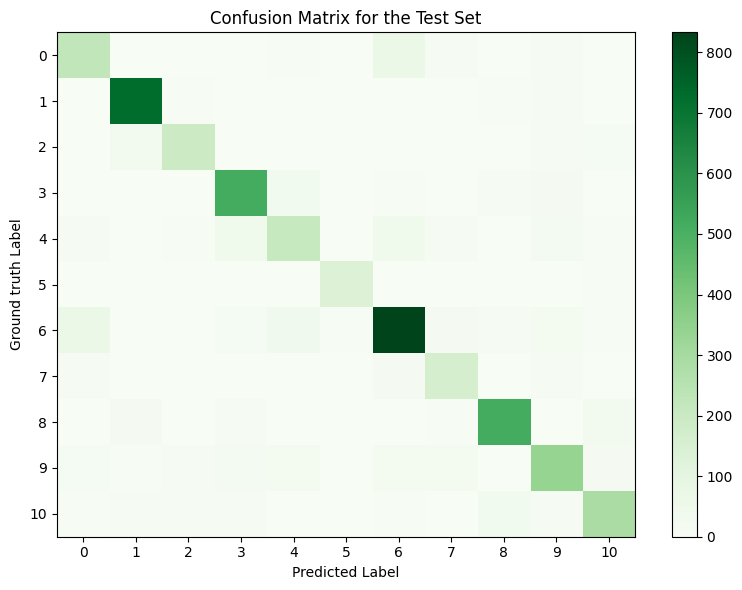

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(labels_true[mask_test], labels_pred[mask_test], labels=np.arange(n_labels))

plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap='Greens', aspect='auto')
plt.title("Confusion Matrix for the Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("Ground truth Label")

tick_marks = np.arange(n_labels)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
articles_top = {}

for a in range(n_labels):
    indx_a = np.where(mask_test & (labels_pred == a))[0]

    if len(indx_a) == 0:
        articles_top[a] = []
        continue

    confs = proba[indx_a, a]

    top5_indx = indx_a[np.argsort(confs)[::-1][:5]]

    articles_top[a] = [names[i] for i in top5_indx]

In [ ]:
for c in articles_top:
    label_name = names_labels[c]
    print(f"\nTop 5 in Label {c} ({label_name}):")
    i=1
    for title in articles_top[c]:
        print(f"  - Top {i}: {title}")
        i+=1


Top 5 in Label 0 (Arts):
  - Top 1: Music
  - Top 2: Painting
  - Top 3: Poetry
  - Top 4: Performing arts
  - Top 5: Drama

Top 5 in Label 1 (Biological and health sciences):
  - Top 1: Permian
  - Top 2: Jurassic
  - Top 3: Flowering plant
  - Top 4: Cambrian
  - Top 5: Mammal

Top 5 in Label 2 (Everyday life):
  - Top 1: Gymnastics
  - Top 2: Water polo
  - Top 3: Swimming (sport)
  - Top 4: Sport of athletics
  - Top 5: Karate

Top 5 in Label 3 (Geography):
  - Top 1: Geographic coordinate system
  - Top 2: Köppen climate classification
  - Top 3: Indian Ocean
  - Top 4: Panama City
  - Top 5: Gulf of Guinea

Top 5 in Label 4 (History):
  - Top 1: First Bulgarian Empire
  - Top 2: Byzantine Empire
  - Top 3: Kievan Rus'
  - Top 4: Roman Empire
  - Top 5: Second Bulgarian Empire

Top 5 in Label 5 (Mathematics):
  - Top 1: Real number
  - Top 2: Algebraic geometry
  - Top 3: Discrete mathematics
  - Top 4: Abstract algebra
  - Top 5: Functional analysis

Top 5 in Label 6 (People):
 

## To do

Compare the results with those obtained with:
* Heat diffusion on the graph.
* Logistic regression on the features.

In [ ]:
from scipy import sparse
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import expm_multiply

In [ ]:
ratio_train = 0.5
rng = np.random.RandomState(8)
mask_train = rng.uniform(size=len(labels_true)) < ratio_train
mask_test = np.logical_not(mask_train)

In [ ]:
n_nodes = adjacency.shape[0]
n_labels = len(np.unique(labels_true))

L = laplacian(adjacency, normed=False)

tau = 1.0

In [ ]:
Y = np.zeros((n_nodes, n_labels))
for idx in np.where(mask_train)[0]:
    Y[idx, labels_true[idx]] = 1

In [ ]:
scores_dif = expm_multiply(-tau * L, Y)
labels_dif = np.argmax(scores_dif, axis=1)

acc_train_diff = get_accuracy_score(labels_true[mask_train], labels_dif[mask_train])
acc_test_diff  = get_accuracy_score(labels_true[mask_test],  labels_dif[mask_test])

print(f"Accuracies with heat diffusion method:\nTrain accuracy: {acc_train_diff:.3f}, Test accuracy: {acc_test_diff:.3f}")


Accuracies with heat diffusion method:
Train accuracy: 0.195, Test accuracy: 0.204


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000, multi_class='multinomial', solver='lbfgs')

logreg.fit(features[mask_train], labels_true[mask_train])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=2000, multi_class='multinomial')

In [ ]:
labels_log = logreg.predict(features)

acc_train_lr = get_accuracy_score(labels_true[mask_train], labels_log[mask_train])
acc_test_lr = get_accuracy_score(labels_true[mask_test], labels_log[mask_test])

print(f"Logistic reg:\nTrain acc: {acc_train_lr:.3f}, Test acc: {acc_test_lr:.3f}")


Logistic reg:
Train acc: 0.809, Test acc: 0.802


Spreading the few known labels solely based on the raw network connections provides only a rough estimate of topic similarity. Even when using an optimal diffusion parameter τ = 1, the accuracy barely reaches around 20%, which is just slightly better than random guessing across 11 categories. This happens because many links in WikiVitals connect different topics, causing the label information to quickly diffuse into incorrect groups.

In contrast, logistic regression performs much better, achieving approximately 80% accuracy. This is largely thanks to the 20-dimensional spectral embedding derived from the article-word bipartite graph, which serves as a rich set of independent features. A simple linear model can separate most classes effectively, yielding nearly equal training and test accuracy and indicating strong generalization with minimal overfitting.

The Graph Neural Network (GNN), however, surpasses logistic regression by integrating both the node features and the local graph structure. While the gain in test accuracy is moderate—because the spectral features already capture much of the graph's global structure—the message passing in the GNN helps refine predictions, especially for nodes near class boundaries.

The heat diffusion results highlight the limitations of relying on the graph structure alone when topic links are densely interconnected. Logistic regression demonstrates the power of well-crafted features. Meanwhile, the GNN shows that combining feature information with graph connectivity provides the most comprehensive solution, although the benefits become less pronounced when the features themselves are already highly informative.